# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ctypes
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

lib = ctypes.CDLL("../target/release/mymodel.dll")

lib.create_rbfn_regression_model.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_size_t]
lib.create_rbfn_regression_model.restype = ctypes.c_void_p

lib.create_rbfn_binary_classification_model.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_size_t]
lib.create_rbfn_binary_classification_model.restype = ctypes.c_void_p


lib.create_rbfn_multiclass_model.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_size_t, ctypes.c_size_t]
lib.create_rbfn_multiclass_model.restype = ctypes.c_void_p


lib.train_rbfn_model_auto.argtypes = [
    ctypes.c_void_p,                        # modèle
    ctypes.POINTER(ctypes.c_double),        # X
    ctypes.POINTER(ctypes.c_double),        # Y
    ctypes.c_size_t,                        # n_samples
    ctypes.c_size_t,                        # n_features
    ctypes.c_size_t                         # n_outputs
]
lib.train_rbfn_model_auto.restype = None

lib.predict_rbfn_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_double), ctypes.c_size_t]
lib.predict_rbfn_model.restype = ctypes.c_double



In [2]:
def train_predict_model(lib, X, Y_labels, learning_rate=0.3, epochs=4000, n_classes=3):
    n_samples, n_features = X.shape
    sigma = learning_rate
    method = 0  # gradient

    model = lib.create_multiclass(n_features, n_classes, sigma, epochs, method)

    X_flat = X.astype(np.float32).flatten()
    X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_float))
    Y_ptr = Y_labels.astype(np.uint32).ctypes.data_as(ctypes.POINTER(ctypes.c_uint))

    lib.train_multiclass(model, X_ptr, Y_ptr, n_samples, n_features, ctypes.c_bool(True))

    preds = np.zeros(n_samples, dtype=np.uint32)
    preds_ptr = preds.ctypes.data_as(ctypes.POINTER(ctypes.c_uint))

    lib.predict_multiclass(model, X_ptr, n_samples, n_features, preds_ptr)

    return model, preds

# Cas de tests, rendu 2

## Classification

### Linear Simple :
        Linear Model : OK
        MLP (2, 1)   : OK

Entrée: [1. 1.], Prédiction: 1.0000
Entrée: [2. 3.], Prédiction: -1.0000
Entrée: [3. 3.], Prédiction: -1.0000


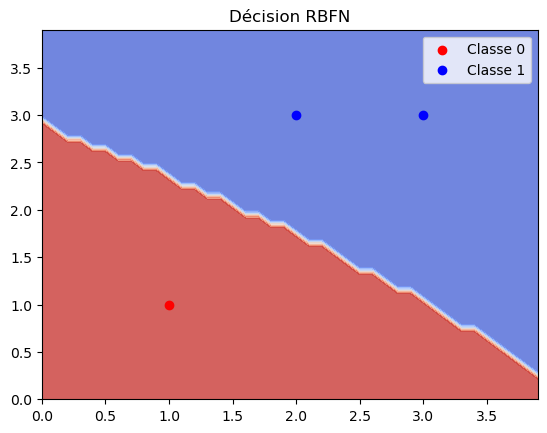

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Données d’entraînement
X = np.array([[1, 1], [2, 3], [3, 3]], dtype=np.float64)
Y = np.array([1, -1, -1], dtype=np.float64)

# Créer et entraîner le modèle
model = lib.create_rbfn_binary_classification_model(1.0, 0.1, 100)

lib.train_rbfn_model_auto(
    model,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X.shape[0],
    X.shape[1],
    1
)

# Affichage des prédictions
for row in X:
    row_ptr = row.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    pred = lib.predict_rbfn_model(model, row_ptr, X.shape[1])
    print(f"Entrée: {row}, Prédiction: {pred:.4f}")
    #print(f"{xi.tolist()} → attendu : {int(yi)}, sortie : {out:.3f} → classe prédite : {classe}")
# === Génération du contour de décision ===
h = 0.1  # taille du pas de grille
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid_points = np.c_[xx.ravel(), yy.ravel()]
Z = []

for pt in grid_points:
    pt_ptr = pt.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    pred = lib.predict_rbfn_model(model, pt_ptr, 2)
    Z.append(pred)

Z = np.array(Z).reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[0, 0], X[0, 1], color="red", label="Classe 0")
plt.scatter(X[1:3, 0], X[1:3, 1], color="blue", label="Classe 1")
plt.legend()
plt.title("Décision RBFN")
plt.show()




### Linear Multiple :
        Linear Model : OK
        MLP (2, 1)   : OK

Prédictions : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Accuracy : 1.0


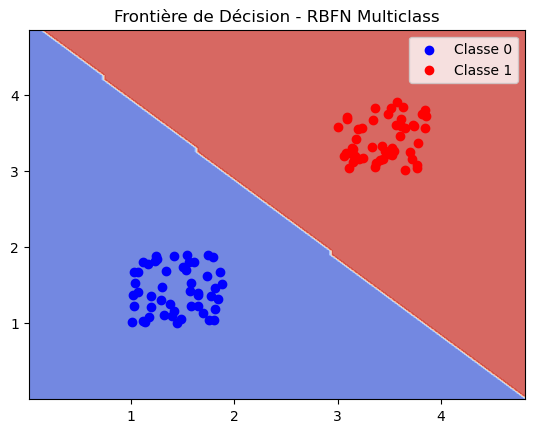

In [4]:
X = np.concatenate([
    np.random.random((50, 2)) * 0.9 + np.array([1, 1]),
    np.random.random((50, 2)) * 0.9 + np.array([3, 3])
]).astype(np.float64)

Y = np.concatenate([
    np.zeros((50,), dtype=np.uint32),
    np.ones((50,), dtype=np.uint32)
])

sigma = 1.5
learning_rate = 0.01
epochs = 1000
n_classes = 2
model = lib.create_rbfn_multiclass_model(sigma, learning_rate, epochs, n_classes)
Y_onehot = np.eye(n_classes)[Y].astype(np.float64)

lib.train_rbfn_model_auto(
    model,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y_onehot.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X.shape[0],
    X.shape[1],
    n_classes
)

preds = np.array([
    int(lib.predict_rbfn_model(
        model,
        x.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[1]
    )) for x in X
], dtype=np.uint32)

print("Prédictions :", preds)
print("Accuracy :", np.mean(preds == Y))


h = 0.05
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)

Z = np.array([
    int(lib.predict_rbfn_model(
        model,
        point.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    )) for point in grid
], dtype=np.uint32)

Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X[:50, 0], X[:50, 1], color="blue", label="Classe 0")
plt.scatter(X[50:, 0], X[50:, 1], color="red", label="Classe 1")
plt.title("Frontière de Décision - RBFN Multiclass")
plt.legend()
plt.show()


### XOR :
        Linear Model    : KO
        MLP (2, 2, 1)   : OK


Prédictions 
Entrée: [1. 0.] → Prédiction: 1.0000
Entrée: [0. 1.] → Prédiction: 1.0000
Entrée: [0. 0.] → Prédiction: -1.0000
Entrée: [1. 1.] → Prédiction: -1.0000


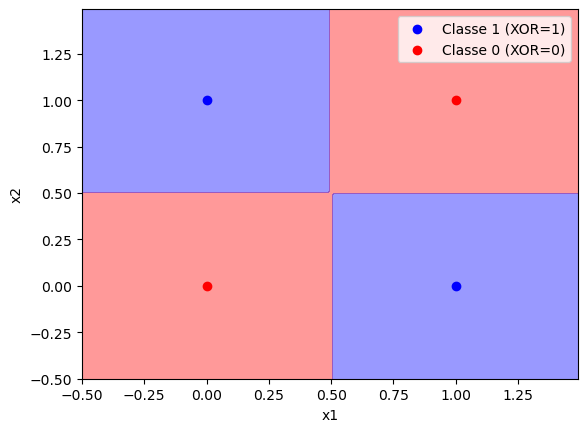

In [5]:
X = np.array([
    [1, 0],
    [0, 1],
    [0, 0],
    [1, 1]
], dtype=np.float64)

Y = np.array([1, 1, -1, -1], dtype=np.float64) 
model = lib.create_rbfn_binary_classification_model(1.0, 0.1, 200)

lib.train_rbfn_model_auto(
    model,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X.shape[0],
    X.shape[1],
    1
)

print("\nPrédictions ")
for row in X:
    row_ptr = row.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    pred = lib.predict_rbfn_model(model, row_ptr, X.shape[1])
    print(f"Entrée: {row} → Prédiction: {pred:.4f}")

h = 0.01
x_min, x_max = -0.5, 1.5
y_min, y_max = -0.5, 1.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = np.array([
    lib.predict_rbfn_model(
        model,
        pt.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    ) for pt in grid
])
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.4, colors=["red", "blue"])
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], color="blue", label="Classe 1 (XOR=1)")
plt.scatter(X[Y == -1][:, 0], X[Y == -1][:, 1], color="red", label="Classe 0 (XOR=0)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()


























































































### Cross :
        Linear Model    : KO
        MLP (2, 4, 1)   : OK

Prédictions (premiers 10 exemples) :
X = [-0.04558869 -0.35371451], Y réel = 1.0, Y prédit = 1
X = [-0.37093971  0.81420601], Y réel = -1.0, Y prédit = -1
X = [ 0.9255402  -0.76376714], Y réel = -1.0, Y prédit = -1
X = [0.45504894 0.5482309 ], Y réel = -1.0, Y prédit = -1
X = [ 0.80257541 -0.11950454], Y réel = 1.0, Y prédit = 1
X = [ 0.60252215 -0.95514978], Y réel = -1.0, Y prédit = -1
X = [ 0.59926684 -0.99315456], Y réel = -1.0, Y prédit = -1
X = [ 0.03075624 -0.41487299], Y réel = 1.0, Y prédit = 1
X = [-0.67673168 -0.32854038], Y réel = -1.0, Y prédit = -1
X = [-0.34147802 -0.11384943], Y réel = 1.0, Y prédit = 1

Précision: 100.00%


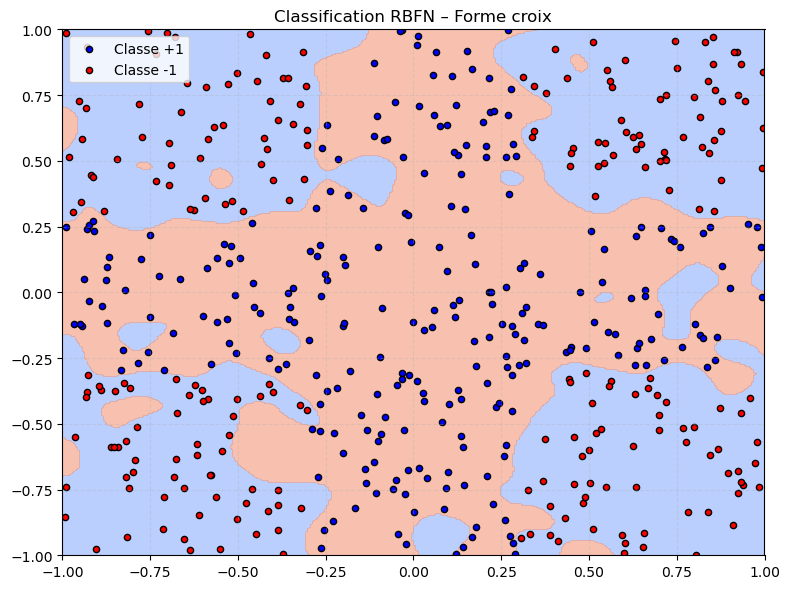

In [6]:
X = np.random.random((500, 2)).astype(np.float64) * 2.0 - 1.0
Y = np.array([1 if abs(p[0]) <= 0.3 or abs(p[1]) <= 0.3 else -1 for p in X], dtype=np.float64)

sigma = 0.1
learning_rate = 0.1
epochs = 500

model = lib.create_rbfn_binary_classification_model(sigma, learning_rate, epochs)

lib.train_rbfn_model_auto(
    model,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X.shape[0],
    X.shape[1],
    1  
)

preds = np.array([
    lib.predict_rbfn_model(
        model,
        x.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[1]
    ) for x in X
])

preds_bin = np.where(preds >= 0, 1.0, -1.0)
print("Prédictions (premiers 10 exemples) :")
for i in range(10):
    print(f"X = {X[i]}, Y réel = {Y[i]}, Y prédit = {preds_bin[i]:.0f}")

accuracy = np.mean(preds_bin == Y)
print(f"\nPrécision: {accuracy:.2%}")

# === Visualisation de la frontière de décision ===
xx, yy = np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1, 1, 300))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)

Z = np.array([
    lib.predict_rbfn_model(
        model,
        pt.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    ) for pt in grid
]).reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, levels=[-1, 0, 1], alpha=0.6, cmap="coolwarm")

plt.scatter(X[Y == 1, 0], X[Y == 1, 1], facecolors="blue", edgecolors="k", label="Classe +1", s=20)
plt.scatter(X[Y == -1, 0], X[Y == -1, 1], facecolors="red", edgecolors="k", label="Classe -1", s=20)

plt.title("Classification RBFN – Forme croix")
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### Multi Linear 3 classes :
        Linear Model x3 : OK
        MLP (2, 3)      : OK

x = [-0.45101858 -0.89021115] → vrai = 0, prédit = 0
x = [-0.35802817 -0.44338757] → vrai = 0, prédit = 0
x = [ 0.70772503 -0.76489146] → vrai = 2, prédit = 2
x = [ 0.77029616 -0.12257015] → vrai = 2, prédit = 2
x = [0.81208804 0.56271328] → vrai = 1, prédit = 1
x = [ 0.83995578 -0.64744665] → vrai = 2, prédit = 2
x = [-0.92618928  0.76513564] → vrai = 1, prédit = 1
x = [-0.18595744  0.7835968 ] → vrai = 1, prédit = 1
x = [ 0.76444448 -0.99432105] → vrai = 2, prédit = 2
x = [ 0.82710561 -0.51758343] → vrai = 2, prédit = 2

Précision : 100.00%


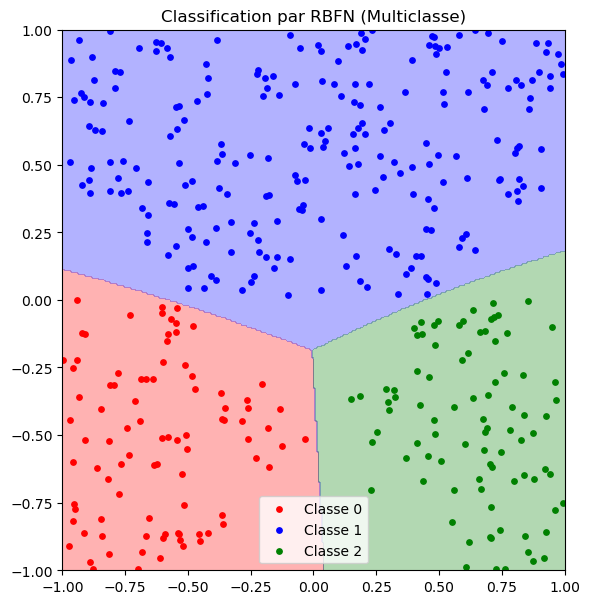

In [9]:
X = np.random.random((500, 2)) * 2.0 - 1.0
Y = np.array([
    (
        [1, 0, 0] if -p[0] - p[1] - 0.5 > 0 and p[1] < 0 and p[0] - p[1] - 0.5 < 0
        else [0, 1, 0] if -p[0] - p[1] - 0.5 < 0 and p[1] > 0 and p[0] - p[1] - 0.5 < 0
        else [0, 0, 1] if -p[0] - p[1] - 0.5 < 0 and p[1] < 0 and p[0] - p[1] - 0.5 > 0
        else [0, 0, 0]
    )
    for p in X
])

valid = Y.sum(axis=1) > 0
X = X[valid].astype(np.float64)
Y = Y[valid].astype(np.float64)
labels = np.argmax(Y, axis=1).astype(np.uint32)
model_ptr = lib.create_rbfn_multiclass_model(1.0, 0.01, 100, 3)

lib.train_rbfn_model_auto(
    model_ptr,
    X.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X.shape[0],
    X.shape[1],
    3
)
predicted = np.zeros(len(labels), dtype=np.uint32)
for i, x in enumerate(X):
    pred = lib.predict_rbfn_model(
        model_ptr,
        x.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[1]
    )
    predicted[i] = int(pred)

accuracy = (predicted == labels).sum() / len(labels) * 100
for i in range(10):
    print(f"x = {X[i]} → vrai = {labels[i]}, prédit = {predicted[i]}")
print(f"\nPrécision : {accuracy:.2f}%")


xx, yy = np.meshgrid(np.linspace(-1, 1, 300), np.linspace(-1, 1, 300))
grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)
Z = np.zeros(len(grid), dtype=np.uint32)

for i, point in enumerate(grid):
    pred = lib.predict_rbfn_model(
        model_ptr,
        point.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    )
    Z[i] = int(pred)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, Z, levels=[-0.5, 0.5, 1.5, 2.5], colors=["red", "blue", "green"], alpha=0.3)

colors = ["red", "blue", "green"]
for i in range(3):
    plt.scatter(X[labels == i][:, 0], X[labels == i][:, 1], color=colors[i], s=15, label=f"Classe {i}")

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.legend()
plt.tight_layout()
plt.title("Classification par RBFN (Multiclasse)")
plt.show()

### Multi Cross :


x = [0.98004581 0.43303118], vrai = 2, prédit = 2
x = [ 0.2918548  -0.50759704], vrai = 2, prédit = 2
x = [0.61544925 0.64165734], vrai = 2, prédit = 2
x = [-0.68739261  0.02688331], vrai = 1, prédit = 2
x = [0.93713987 0.30556511], vrai = 2, prédit = 2
x = [0.48487203 0.24112582], vrai = 1, prédit = 2
x = [ 0.47911382 -0.34644303], vrai = 1, prédit = 2
x = [0.99414009 0.62232562], vrai = 1, prédit = 2
x = [-0.35833872  0.232379  ], vrai = 2, prédit = 2
x = [ 0.82659735 -0.92280557], vrai = 1, prédit = 2

Précision : 50.90%


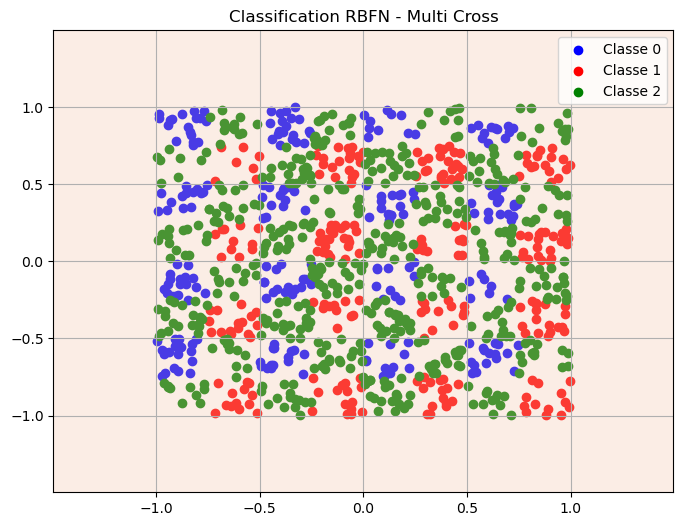

In [28]:

X = np.random.random((1000, 2)) * 2.0 - 1.0

Y = np.array([
    [1, 0, 0] if abs(p[0] % 0.5) <= 0.25 and abs(p[1] % 0.5) > 0.25
    else [0, 1, 0] if abs(p[0] % 0.5) > 0.25 and abs(p[1] % 0.5) <= 0.25
    else [0, 0, 1]
    for p in X
])
Y_labels = np.argmax(Y, axis=1)

sigma = 1.5
learning_rate = 0.0001
epochs = 800
n_classes = 3

model = lib.create_rbfn_multiclass_model(sigma, learning_rate, epochs, n_classes)

lib.train_rbfn_model_auto(
    model,
    X.flatten().astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    Y.flatten().astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
    X.shape[0],
    X.shape[1],
    n_classes
)
Y_pred = np.array([
    int(lib.predict_rbfn_model(
        model,
        x.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        X.shape[1]
    )) for x in X
], dtype=np.uint32)


plt.figure(figsize=(8, 6))
plt.scatter(X[Y[:, 0] == 1][:, 0], X[Y[:, 0] == 1][:, 1], color="blue", label="Classe 0")
plt.scatter(X[Y[:, 1] == 1][:, 0], X[Y[:, 1] == 1][:, 1], color="red", label="Classe 1")
plt.scatter(X[Y[:, 2] == 1][:, 0], X[Y[:, 2] == 1][:, 1], color="green", label="Classe 2")

xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5, 200),
    np.linspace(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5, 200)
)
grid_points = np.c_[xx.ravel(), yy.ravel()].astype(np.float64)

Z = np.array([
    int(lib.predict_rbfn_model(
        model,
        pt.ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        2
    )) for pt in grid_points
], dtype=np.uint32)

Z = Z.reshape(xx.shape)

accuracy = np.mean(Y_labels == Y_pred) * 100
for i in range(10):
    print(f"x = {X[i]}, vrai = {Y_labels[i]}, prédit = {Y_pred[i]}")
print(f"\nPrécision : {accuracy:.2f}%")

plt.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(-0.5, 4), cmap="coolwarm")
plt.legend()
plt.title("Classification RBFN - Multi Cross")
plt.grid(True)
plt.show()


## Régression

### Linear Simple 2D :
        Linear Model : OK
        MLP (1, 1)   : OK

x = 1.00 | vrai = 2.00 | prédit = 2.0000
x = 2.00 | vrai = 3.00 | prédit = 3.0000
x = 1.50 | vrai = 2.50 | prédit = 2.7466


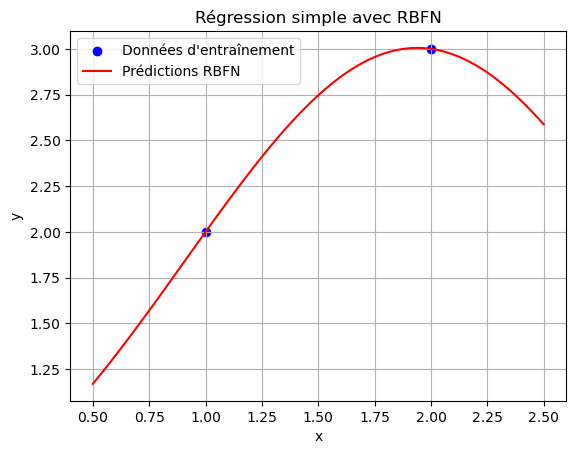

In [4]:
X = np.array([[1], [2]], dtype=np.float64)
Y = np.array([2, 3], dtype=np.float64)

n_samples, n_features = X.shape
n_outputs = 1

X_ptr = X.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double))
Y_ptr = Y.flatten().ctypes.data_as(ctypes.POINTER(ctypes.c_double))

sigma = 1.0
learning_rate = 0.1
epochs = 100

model = lib.create_rbfn_regression_model(sigma, learning_rate, epochs)
lib.train_rbfn_model_auto(model, X_ptr, Y_ptr, n_samples, n_features, n_outputs)


for x_val in [1.0, 2.0, 1.5]:
    x_test = np.array([x_val], dtype=np.float64)
    x_ptr = x_test.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, 1)
    print(f"x = {x_val:.2f} | vrai = {x_val + 1:.2f} | prédit = {y_pred:.4f}")

x_range = np.linspace(0.5, 2.5, 100).reshape(-1, 1)

y_preds = [
    lib.predict_rbfn_model(
        model, 
        x_val.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double)),
        1
    )
    for x_val in x_range
]

plt.scatter(X, Y, label="Données d'entraînement", color="blue")
plt.plot(x_range, y_preds, color="red", label="Prédictions RBFN")
plt.title("Régression simple avec RBFN")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()


### Non Linear Simple 2D :
        Linear Model    : OK
        MLP (1, ?, 1)   : OK

x = 1.00 | predit = 2.0000
x = 2.00 | predit = 3.0000
x = 3.00 | predit = 2.5000
x = 2.50 | predit = 2.8362


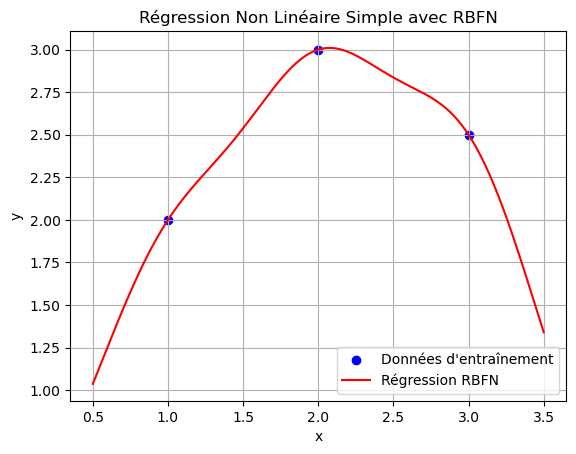

<Figure size 640x480 with 0 Axes>

In [5]:
X = np.array([[1], [2], [3]], dtype=np.float64)
Y = np.array([2, 3, 2.5], dtype=np.float64)

n_samples, n_features = X.shape
n_outputs = 1

X_flat = X.flatten()
Y_flat = Y.flatten()

X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
Y_ptr = Y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

sigma = 0.5
learning_rate = 0.1
epochs = 200
model = lib.create_rbfn_regression_model(sigma, learning_rate, epochs)

lib.train_rbfn_model_auto(model, X_ptr, Y_ptr, n_samples, n_features, n_outputs)

x_range = np.linspace(0.5, 3.5, 200).reshape(-1, 1)
y_preds = []
for x_val in x_range:
    x_ptr = x_val.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, 1)
    y_preds.append(y_pred)


for x_val in [1.0, 2.0, 3.0, 2.5]:
    x_test = np.array([x_val], dtype=np.float64)
    x_ptr = x_test.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, 1)
    print(f"x = {x_val:.2f} | predit = {y_pred:.4f}")

plt.scatter(X, Y, label="Données d'entraînement", color="blue")
plt.plot(x_range, y_preds, color="red", label="Régression RBFN")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Régression Non Linéaire Simple avec RBFN")
plt.legend()
plt.grid(True)
plt.show()
plt.clf()

### Linear Simple 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

x = 1.00 | y_prédit = 2.0000
x = 2.00 | y_prédit = 3.0000
x = 3.00 | y_prédit = 2.5000
x = 2.50 | y_prédit = 2.8362


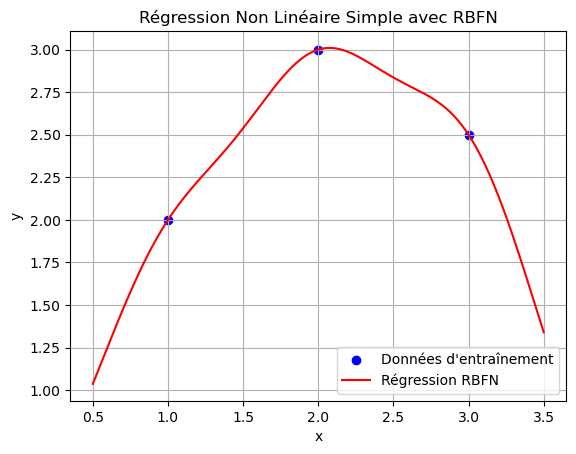

<Figure size 640x480 with 0 Axes>

In [6]:
X = np.array([[1], [2], [3]], dtype=np.float64)
Y = np.array([2, 3, 2.5], dtype=np.float64)

n_samples, n_features = X.shape
n_outputs = 1

X_flat = X.flatten()
Y_flat = Y.flatten()

X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
Y_ptr = Y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

sigma = 0.5
learning_rate = 0.1
epochs = 200
model = lib.create_rbfn_regression_model(sigma, learning_rate, epochs)

lib.train_rbfn_model_auto(model, X_ptr, Y_ptr, n_samples, n_features, n_outputs)

x_range = np.linspace(0.5, 3.5, 200).reshape(-1, 1)
y_preds = []
for x_val in x_range:
    x_ptr = x_val.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, 1)
    y_preds.append(y_pred)


for x_val in [1.0, 2.0, 3.0, 2.5]:
    x_test = np.array([x_val], dtype=np.float64)
    x_ptr = x_test.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, 1)
    print(f"x = {x_val:.2f} | y_prédit = {y_pred:.4f}")

# Affichage graphique
plt.scatter(X, Y, label="Données d'entraînement", color="blue")
plt.plot(x_range, y_preds, color="red", label="Régression RBFN")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Régression Non Linéaire Simple avec RBFN")
plt.legend()
plt.grid(True)
plt.show()
plt.clf()

### Linear Tricky 3D :
        Linear Model    : OK
        MLP (2, 1)      : OK

x = [1. 1.] | vrai = 1.00 | prédit = 1.0000
x = [2. 2.] | vrai = 2.00 | prédit = 2.0000
x = [3. 3.] | vrai = 3.00 | prédit = 3.0000

RMSE sur les données d'entraînement : 0.0000


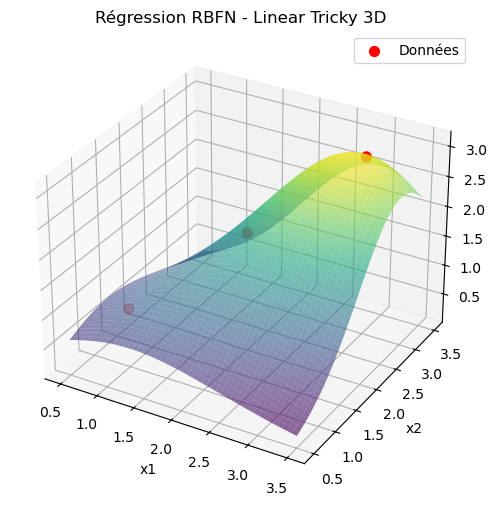

In [7]:

X = np.array([
    [1, 1],
    [2, 2],
    [3, 3]
], dtype=np.float64)

Y = np.array([1, 2, 3], dtype=np.float64)

n_samples, n_features = X.shape
n_outputs = 1

X_flat = X.flatten()
Y_flat = Y.flatten()

X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
Y_ptr = Y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

sigma = 1.0
learning_rate = 0.1
epochs = 200
model = lib.create_rbfn_regression_model(sigma, learning_rate, epochs)
lib.train_rbfn_model_auto(model, X_ptr, Y_ptr, n_samples, n_features, n_outputs)

y_preds_train = []
for i, x_val in enumerate(X):
    x_ptr = x_val.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, n_features)
    y_preds_train.append(y_pred)
    print(f"x = {x_val} | vrai = {Y[i]:.2f} | prédit = {y_pred:.4f}")

# Calcul de la précision (RMSE)
y_preds_train = np.array(y_preds_train)
mse = np.mean((Y - y_preds_train) ** 2)
rmse = np.sqrt(mse)
print(f"\nRMSE sur les données d'entraînement : {rmse:.4f}")

x1_vals = np.linspace(0.5, 3.5, 50)
x2_vals = np.linspace(0.5, 3.5, 50)
xx, yy = np.meshgrid(x1_vals, x2_vals)
grid_points = np.c_[xx.ravel(), yy.ravel()]
y_preds = []


for point in grid_points:
    x_ptr = point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, 2)
    y_preds.append(y_pred)

zz = np.array(y_preds).reshape(xx.shape)


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, cmap="viridis", alpha=0.6, edgecolor='none')
ax.scatter(X[:, 0], X[:, 1], Y, color="red", s=50, label="Données")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression RBFN - Linear Tricky 3D")
ax.legend()
plt.show()


### Non Linear Simple 3D :
        Linear Model       : KO
        MLP (2, 2, 1)      : OK

x = [1. 0.] | vrai = 2.00 | prédit = 2.0000
x = [0. 1.] | vrai = 1.00 | prédit = 1.0000
x = [1. 1.] | vrai = -2.00 | prédit = -2.0000
x = [0. 0.] | vrai = -1.00 | prédit = -1.0000


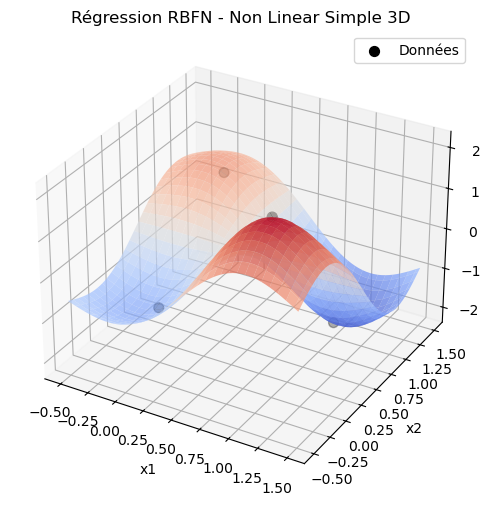

In [8]:
X = np.array([
    [1, 0],
    [0, 1],
    [1, 1],
    [0, 0]
], dtype=np.float64)

Y = np.array([2, 1, -2, -1], dtype=np.float64)

n_samples, n_features = X.shape
n_outputs = 1

X_flat = X.flatten()
Y_flat = Y.flatten()

X_ptr = X_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
Y_ptr = Y_flat.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

sigma = 0.5
learning_rate = 0.1
epochs = 300
model = lib.create_rbfn_regression_model(sigma, learning_rate, epochs)
lib.train_rbfn_model_auto(model, X_ptr, Y_ptr, n_samples, n_features, n_outputs)

y_preds_train = []
for i, x_val in enumerate(X):
    x_ptr = x_val.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, n_features)
    y_preds_train.append(y_pred)
    print(f"x = {x_val} | vrai = {Y[i]:.2f} | prédit = {y_pred:.4f}")

x1_vals = np.linspace(-0.5, 1.5, 60)
x2_vals = np.linspace(-0.5, 1.5, 60)
xx, yy = np.meshgrid(x1_vals, x2_vals)
grid_points = np.c_[xx.ravel(), yy.ravel()]
y_preds = []

for point in grid_points:
    x_ptr = point.astype(np.float64).ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    y_pred = lib.predict_rbfn_model(model, x_ptr, 2)
    y_preds.append(y_pred)

zz = np.array(y_preds).reshape(xx.shape)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz, cmap="coolwarm", alpha=0.7, edgecolor='none')
ax.scatter(X[:, 0], X[:, 1], Y, color="black", s=50, label="Données")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("y")
ax.set_title("Régression RBFN - Non Linear Simple 3D")
ax.legend()
plt.show()